In [13]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [8]:
#R code 5.1
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';', header=0)
d['age_norm'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['divorce_norm'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()
d['marriage_norm'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()

In [3]:
#R code 5.2
d.MedianAgeMarriage.std()

1.243630301388082

In [40]:
#R code 5.3 (out of order intentionally)
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_age*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_1 = pm.sample(1000, tune=1000, chains=1) 
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2084.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
varnames = ['alpha','beta_age','sigma']
pm.summary(trace_5_1, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-0.00,0.10,0.0,-0.16,0.16,5814.33,1.0
beta_age,-0.56,0.11,0.0,-0.75,-0.39,5092.00,1.0
sigma,0.82,0.09,0.0,0.68,0.95,5269.19,1.0


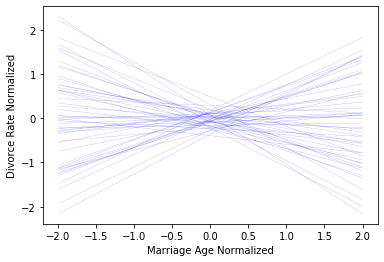

In [6]:
#R code 5.4. There are probably better ways to do this.
x = np.linspace(-2, 2, 100)
z=0
while z < 50:
    plt.plot(x, prior['alpha'][z] + prior['beta_age'][z]*x, linewidth=0.1, color='b')
    z+=1
plt.xlabel('Marriage Age Normalized')
plt.ylabel('Divorce Rate Normalized');

#The graph below shows that the priors we chose were bad. The standard deviation of the median age of marriage (not
#normalized) is 1.2 (R code 5.2). So, when the normalized marriage age is 1.0 (corresponding to an increase of age)
#of 1.2 years, our priors permit an increase in divorce rate by one full standard deviation.

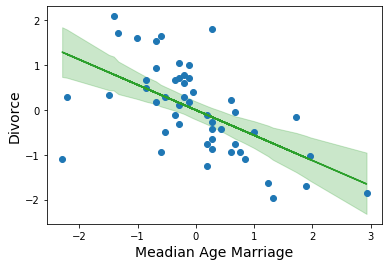

In [7]:
#R code 5.5, figure 5.2 (right)

mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.age_norm, d.divorce_norm, 'C0o')
plt.plot(d.age_norm, mu_mean.mean(0), 'C2')

idx = np.argsort(d.age_norm)
plt.fill_between(d.age_norm[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2119.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


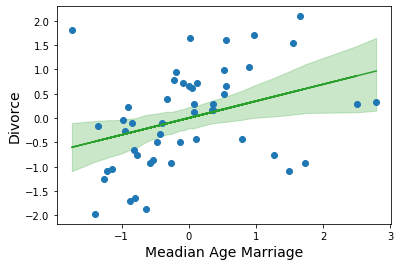

In [37]:
#R code 5.6, figure 5.2 (left)
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_marriage*d.marriage_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_2 = pm.sample(1000, tune=1000, chains=1) 
    #prior = pm.sample_prior_predictive()
    
mu_mean_marriage = trace_5_2['mu']
mu_hpd_marriage = pm.hpd(mu_mean_marriage)

plt.plot(d.marriage_norm, d.divorce_norm, 'C0o')
plt.plot(d.marriage_norm, mu_mean_marriage.mean(0), 'C2')

idx = np.argsort(d.marriage_norm)
plt.fill_between(d.marriage_norm[idx],
                 mu_hpd_marriage[:,0][idx], mu_hpd_marriage[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

In [38]:
varnames = ['alpha', 'beta_marriage', 'sigma']
pm.summary(trace_5_2, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.00,0.11,0.0,-0.18,0.18
beta_marriage,0.35,0.13,0.0,0.14,0.56
sigma,0.95,0.09,0.0,0.80,1.09


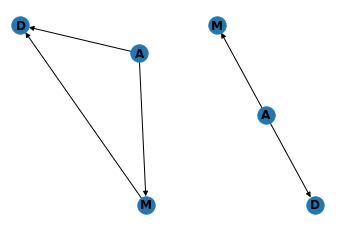

In [29]:
#Practicing making graphs

G1=nx.DiGraph()
G2=nx.DiGraph()
G1.add_edges_from([("A", "M"), ("A", "D"), ("M", "D")])
G2.add_edges_from([("A", "M"), ("A", "D")])
plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.show();

In [42]:
#R code 5.8
with pm.Model() as m_5_3:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=0.5) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_marriage*d.marriage_norm + beta_age*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_5_3 = pm.sample(1000, tune=1000, chains=1) 
    #prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, beta_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [43]:
varnames = ['alpha', 'beta_marriage', 'beta_age', 'sigma'] 
pm.summary(trace_5_3, varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,-0.00,0.10,0.00,-0.15,0.17
beta_marriage,-0.06,0.16,0.01,-0.31,0.20
beta_age,-0.61,0.16,0.01,-0.87,-0.38
sigma,0.83,0.09,0.00,0.69,0.96


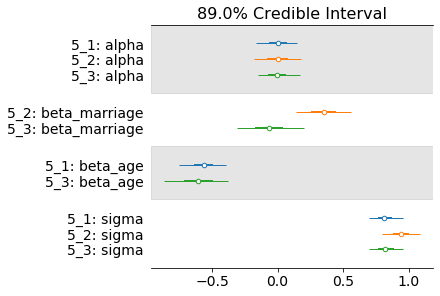

In [54]:
#R code 5.9
pm.forestplot((trace_5_1, trace_5_2, trace_5_3), model_names = ("5_1","5_2","5_3"), 
              var_names=varnames, credible_interval=0.89, linewidth=1, figsize=(6,4));

In [56]:
#R code 5.11
with pm.Model() as m_5_4:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_age_marriage = pm.Normal('beta_age_marriage', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_age_marriage*d.age_norm)
    sigma = pm.Exponential('sigma', 1)
    marriage = pm.Normal('marriage', mu=mu, sd=sigma, observed=d.marriage_norm)
    trace_5_4 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age_marriage, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2082.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [61]:
#R code 5.12
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.marriage_norm - mu_pred